In [ ]:
#General comments about this code 
#Time steps 277 and 287 are discarded (are they still?)

In [20]:
import os

os.environ['NUMPY_EXPERIMENTAL_ARRAY_FUNCTION'] = '0'
import xarray as xr
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon
from matplotlib import pyplot as pltt
%matplotlib inline
import numpy as np
import intake
import fsspec
import xmitgcm

In [21]:
cat = intake.Catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean.yaml")
ds_faces1 = cat["ECCOv4r3"].to_dask()
ds_faces2 = xr.open_zarr(fsspec.get_mapper('gcs://pangeo-data/ECCO_layers.zarr'))
ds_faces=xr.merge((ds_faces1,ds_faces2))

In [22]:
#for more info on how this mask works, see https://github.com/ECCO-GROUP/ECCOv4-py/blob/master/ecco_v4_py/get_basin.py
all_basins = xmitgcm.utils.read_3d_llc_data('/home/jovyan/basins.data', nx=90,nz=1,nrecs=1,dtype='>f')
mask_2d = ds_faces['hFacC'].isel(k=0)
basin_mask = 0*mask_2d
basin_mask = (basin_mask + mask_2d.where(all_basins.squeeze() == 2,0)+ mask_2d.where(all_basins.squeeze() == 7,0)
              + mask_2d.where(all_basins.squeeze() == 9,0)
             + mask_2d.where(all_basins.squeeze() == 10,0)
             + mask_2d.where(all_basins.squeeze() == 12,0)
             + mask_2d.where(all_basins.squeeze() == 18,0)
             + mask_2d.where(all_basins.squeeze() == 19,0))
basin_mask = (basin_mask * mask_2d).drop(['PHrefC','Z','drF','hFacC','maskC'])
ds_with_mask=xr.merge((ds_faces,basin_mask.rename('atl_maskC')))
mask_2d = ds_faces['hFacS'].isel(k=0)
basin_mask = 0*mask_2d
basin_mask = (basin_mask + mask_2d.where(all_basins.squeeze() == 2,0)+ mask_2d.where(all_basins.squeeze() == 7,0)
              + mask_2d.where(all_basins.squeeze() == 9,0)
             + mask_2d.where(all_basins.squeeze() == 10,0)
             + mask_2d.where(all_basins.squeeze() == 12,0)
             + mask_2d.where(all_basins.squeeze() == 18,0)
             + mask_2d.where(all_basins.squeeze() == 19,0))
basin_mask = (basin_mask * mask_2d).drop(['PHrefC','Z','drF','hFacS','maskS'])
ds_with_mask2=xr.merge((ds_with_mask,basin_mask.rename('atl_maskS')))
mask_2d = ds_faces['hFacW'].isel(k=0)
basin_mask = 0*mask_2d
basin_mask = (basin_mask + mask_2d.where(all_basins.squeeze() == 2,0)+ mask_2d.where(all_basins.squeeze() == 7,0)
              + mask_2d.where(all_basins.squeeze() == 9,0)
             + mask_2d.where(all_basins.squeeze() == 10,0)
             + mask_2d.where(all_basins.squeeze() == 12,0)
             + mask_2d.where(all_basins.squeeze() == 18,0)
             + mask_2d.where(all_basins.squeeze() == 19,0))
basin_mask = (basin_mask * mask_2d).drop(['PHrefC','Z','drF','hFacW','maskW'])
ds_with_mask3=xr.merge((ds_with_mask2,basin_mask.rename('atl_maskW')))

In [23]:
ds_ll = faces_dataset_to_latlon(ds_with_mask3, metric_vector_pairs=[('LaHw3RHO','LaHs3RHO'),('atl_maskW','atl_maskS')])#.compute()
ds = (ds_ll.reset_coords(drop=True).roll(i=180, roll_coords=False).roll(i_g=180, roll_coords=False))
coords = (ds_ll.coords.to_dataset().reset_coords().roll(i=180, roll_coords=False).roll(i_g=180, roll_coords=False))

In [24]:
dt = ds.time_snp[1:].load()
dt.values = [float(t)/10**9 for t in np.diff(ds.time_snp)]
dt = dt.rename({'time_snp':'time'})
dt.time.values = ds.time.values[1:-1] 
ds = ds.assign_coords(dt=dt)
ds.dt.attrs = {'units': 's','standard_name': 'dt','coordinate': 'time','long_name': 'time span between snapshots'}

In [25]:
#Makes array of total volume transport above sigma=101 in the basin as a function of time
tr = (ds.LaVH3RHO * coords.dxG * ds.atl_maskS)[:, :101, 210, :].sum('l3_c') 
volume_over_time = tr.sum('i') 
#volume_over_time.load()
volume_over_time

<xarray.DataArray (time: 288)>
dask.array<sum-aggregate, shape=(288,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    j_g      int64 210
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
    dt       (time) float64 nan 2.506e+06 2.678e+06 ... 2.678e+06 2.592e+06 nan

In [26]:
#Makes array of i-star at each time 
volume_over_i = tr.cumsum('i')[:, 110:180] - volume_over_time 
#istar_over_time = (volume_over_i <0).argmax(dim='i') - yields an array of only zeroes
istar_over_time = np.argmax((volume_over_i>0)[:, :],axis=1) 

In [27]:
#Interpolates longitude from j to j_g then creates array of "real" longitude over time 
from xgcm import Grid 
grid = Grid(ds, coords={'Y':{'center':'j', 'left':'j_g'}})
l_i = grid.interp(coords.XC, axis = 'Y')
long_interp = l_i[210, :]
istar1 = istar_over_time + 110
istar2 = long_interp[istar1]
#istar2.load()

In [10]:
#Sigma is 101 and j_g is 210
rho0=1029 
cp=3994
a = (ds.LaAy3RHO * ds.atl_maskS * rho0 * cp)[:, :, 210, :] #(time, l3_c, i)

In [11]:
#Top left 
adv1 = a.where(a.i < istar1)
top_left = adv1[:, :101, :].sum(['i','l3_c'])
top_left.load()

<xarray.DataArray (time: 288)>
array([6.17863906e+14, 5.41354230e+14, 5.98459629e+14, 5.50614494e+14,
       7.43152138e+14, 7.49715128e+14, 7.68559880e+14, 8.21179117e+14,
       9.88120522e+14, 9.44499635e+14, 7.88765770e+14, 7.16944142e+14,
       5.01177956e+14, 9.73663539e+14, 7.95353929e+14, 8.49743301e+14,
       7.80213353e+14, 7.89551238e+14, 8.67671395e+14, 8.97499599e+14,
       9.44943126e+14, 9.69059482e+14, 8.88035116e+14, 8.13126567e+14,
       6.83270020e+14, 2.91394429e+14, 6.16402098e+14, 7.09835307e+14,
       6.37060324e+14, 9.62580184e+14, 7.45507163e+14, 7.55816372e+14,
       7.22416364e+14, 9.84828842e+14, 8.03411157e+14, 7.11548472e+14,
       7.57751868e+14, 7.15937647e+14, 9.42045521e+14, 6.70540603e+14,
       5.67138519e+14, 9.49556208e+14, 9.55690100e+14, 8.85953158e+14,
       1.04729302e+15, 1.06632100e+15, 9.66903931e+14, 4.94651215e+14,
       4.73641858e+14, 9.08053185e+14, 7.98132699e+14, 7.42265952e+14,
       9.83565298e+14, 9.59915380e+14, 1.02919

In [12]:
#Top right 
adv2 = a.where(a.i >= istar1)
top_right = adv2[:, :101, :].sum(['i','l3_c'])
top_right.load()

<xarray.DataArray (time: 288)>
array([ 7.04279828e+13,  1.62463945e+14,  2.06897285e+14,  2.11296576e+14,
        1.67050001e+14,  1.27824168e+14,  6.49749870e+13,  7.40705958e+13,
        7.48140371e+13,  5.58213235e+12, -6.15092649e+13,  4.00586711e+13,
        1.43944379e+14,  1.93579520e+13,  3.34046927e+12,  2.72435996e+13,
        4.52669261e+13,  1.01475438e+14,  8.24581217e+13,  4.36944985e+13,
        4.01679642e+13,  9.31083300e+12,  9.02368060e+13,  9.11142865e+13,
        8.08611391e+13,  3.07176971e+13,  2.13438922e+14,  3.05689715e+14,
        2.12376899e+14,  5.98232963e+13,  1.99564913e+14,  1.45010534e+14,
        1.72663510e+14, -2.85027312e+13, -3.04588451e+13,  1.48356328e+14,
        7.51231648e+13, -3.16708838e+13,  2.74909928e+13,  8.85672618e+13,
        1.13656597e+14,  1.39716545e+14, -5.25166215e+12, -5.72942634e+12,
        5.79035708e+13, -4.49249408e+13, -4.78679180e+13, -8.51352594e+13,
        6.68775149e+13, -1.70406248e+12, -4.22341352e+13,  1.80904123

In [16]:
#Bottom 
bottom = a[:, 101:, :].sum(['l3_c', 'i'])
bottom.load()

<xarray.DataArray (time: 288)>
array([-2.54975795e+14, -2.85562020e+14, -2.88661465e+14, -2.85045293e+14,
       -2.75132355e+14, -2.69794668e+14, -2.64858854e+14, -2.50507956e+14,
       -2.69075191e+14, -2.61778210e+14, -2.26985655e+14, -2.20037988e+14,
       -2.42683189e+14, -3.08719787e+14, -2.51812790e+14, -2.94363771e+14,
       -2.67488617e+14, -2.66861545e+14, -2.70815472e+14, -2.64960962e+14,
       -2.62143912e+14, -2.68708809e+14, -2.54797898e+14, -2.69195685e+14,
       -2.82917310e+14, -1.82910944e+14, -2.80979170e+14, -2.91031751e+14,
       -2.58865460e+14, -2.70163468e+14, -2.67258990e+14, -2.64689506e+14,
       -2.57701879e+14, -2.75584089e+14, -2.32298036e+14, -2.41082942e+14,
       -2.92245383e+14, -2.87778663e+14, -3.17977610e+14, -2.65505815e+14,
       -2.73210167e+14, -2.88383374e+14, -2.81708712e+14, -2.61256241e+14,
       -3.02817182e+14, -2.84654991e+14, -2.62134430e+14, -1.92954865e+14,
       -2.15087055e+14, -2.99704537e+14, -2.77209167e+14, -2.77603483

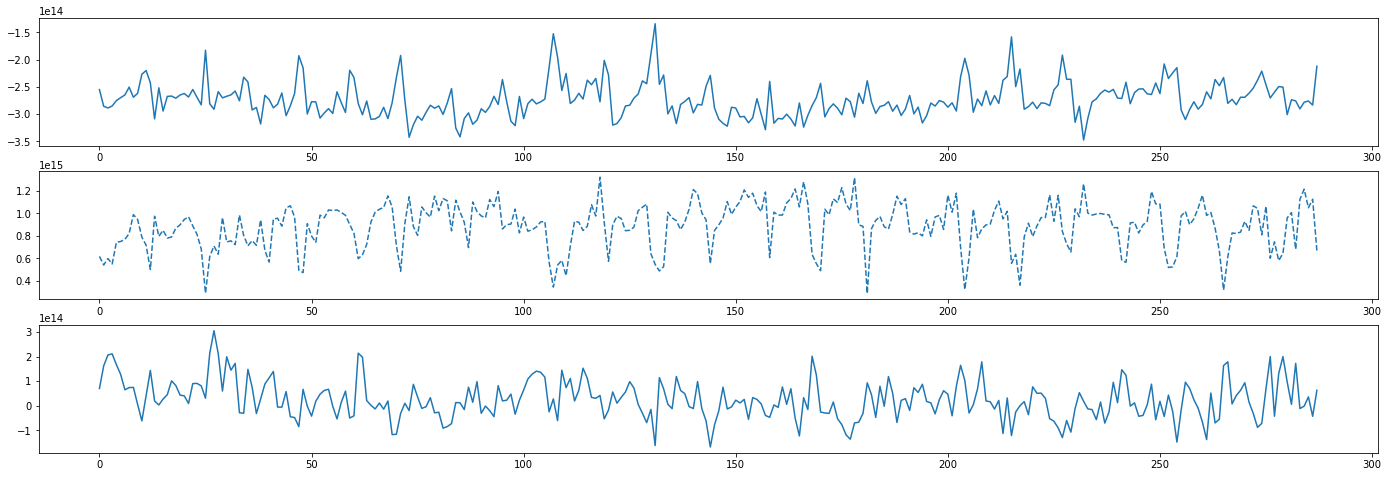

In [17]:
fig, axs = pltt.subplots(3, figsize=(24,8))
axs[0].plot(bottom)
axs[1].plot(top_left, ls='--')
axs[2].plot(top_right)

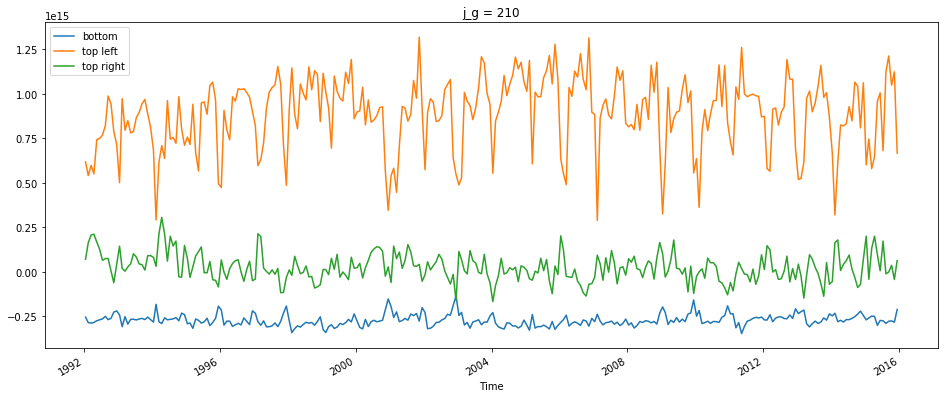

In [19]:
fig, ax = pltt.subplots(figsize=(16,6))
(bottom).plot(ax=ax)
(top_left).plot(ax=ax)
(top_right).plot(ax=ax)
ax.legend(("bottom", "top left", "top right"),loc='upper left')

In [ ]:
#Interpolation
nextcell_volume = tr.where(tr.i < istar3).sum('i') #volume of the next cell
difference = nextcell_volume - volume_at_istar #volume difference (ie. length of cell) denominator
ratio = (volume_over_time - volume_at_istar) / difference 
smooth_longitude =  ratio + istar2
